In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from utils.graphs_config import ABC_3, edges2topology, adj2edges
from utils.functions import fit_step_titanic, calc_accuracy_titanic, get_cumulative_train_loss, update_params_titanic
from networks.logreg_model_titanic import LogRegTitanic

from utils.consensus_node import ConsensusNode
from utils.master_node import MasterNode

In [2]:
topology = edges2topology(adj2edges(ABC_3))
n_agents = len(topology)
pprint(topology)

defaultdict(<class 'dict'>,
            {'Alice': {'Alice': 0.3333333333161983,
                       'Bob': 0.33333333334053794,
                       'Charlie': 0.33333333334326376},
             'Bob': {'Alice': 0.33333333334053794,
                     'Bob': 0.33333333333233983,
                     'Charlie': 0.3333333333271223},
             'Charlie': {'Alice': 0.33333333334326376,
                         'Bob': 0.3333333333271223,
                         'Charlie': 0.333333333329614}})


In [3]:
dataset_name = 'titanic'

In [4]:
# prepare dataset
if dataset_name == 'cifar10':
    
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ]) # meanstd transformation

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cf.mean[dataset_name], cf.std[dataset_name]),
    ])
    
    trainset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                            train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='../data/cifar10',
                                           train=False, download=False,
                                           transform=transform_test)
   
    indices = [i for i in range(len(trainset))]
    np.random.shuffle(indices)
    indices = indices[:n_agents*(len(trainset) // n_agents)]
    indices = np.array_split(indices, n_agents)
    subsets = [torch.utils.data.Subset(trainset, indices=ind) for ind in indices]
    train_loaders = {node_name: torch.utils.data.DataLoader(subset,
                                                       batch_size=batch_size,
                                                       shuffle=True,
                                                       num_workers=2)
                for node_name, subset in zip(topology, subsets)
               }
    test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

elif dataset_name == 'titanic':
    def prepare_dataset(df):
        df = df.drop(['Name', 'Ticket', 'Cabin', 'Embarked'], axis=1)
        df['Sex'] = (train_data['Sex'] == 'male').astype(np.int) * 2 - 1
        df = df.fillna({'Age': df['Age'].mean()})
        df['Age'] /= 100
        df['Fare'] /= 100
        df['_bias'] = 1
        if 'Survived' in df.columns:
            return df.drop(['Survived'], axis=1), (df['Survived'] * 2 - 1)
        else:
            return df
    
    train_data = pd.read_csv('../data/titanic/train.csv')
    train_data = train_data.sample(frac=1)
    train_features, train_answers = prepare_dataset(train_data)

    features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', '_bias']
    X = train_features[features].to_numpy()
    y = train_answers.to_numpy()

    common_test_X, common_test_y = X[:X.shape[0] // 10], y[:X.shape[0] // 10]
    X_train, y_train = X[X.shape[0] // 10:], y[X.shape[0] // 10:]
    
    X_train_parts = np.array_split(X_train, n_agents)
    y_train_parts = np.array_split(y_train, n_agents)
    
    train_loaders = {node_name: [(x, y)] for node_name, x, y in zip(topology, X_train_parts, y_train_parts)}
    test_loader = (common_test_X, common_test_y)
else:
    print("This dataset is not yet supported.")
    exit(0)

In [5]:
stat_step  = 100
num_epochs = 20000
epoch_len  = 1

In [6]:
stat_funcs = {'test_accuracy': calc_accuracy_titanic, 'cumulative_train_loss': get_cumulative_train_loss}
statistics = {func_name: {node_name: {'values': [], 'iters': [], 'tmp': 0.0} 
                          for node_name in topology}
              for func_name in stat_funcs}
pprint(statistics)
# statistics['func_name']['node_name']['values/iters/tmp']

{'cumulative_train_loss': {'Alice': {'iters': [], 'tmp': 0.0, 'values': []},
                           'Bob': {'iters': [], 'tmp': 0.0, 'values': []},
                           'Charlie': {'iters': [], 'tmp': 0.0, 'values': []}},
 'test_accuracy': {'Alice': {'iters': [], 'tmp': 0.0, 'values': []},
                   'Bob': {'iters': [], 'tmp': 0.0, 'values': []},
                   'Charlie': {'iters': [], 'tmp': 0.0, 'values': []}}}


In [7]:
# init master node
master = MasterNode(node_names=topology.keys(),
                    weights=topology, # param_a = a*param_a + b*param_b + c*param_c, where a + b + c = 1.0
                    train_loaders=train_loaders, # dict of train loaders, train_loaders[node_name] = train loader for node_name
                    test_loader=test_loader, # general test loader
                    fit_step=fit_step_titanic,
                    update_params=update_params_titanic,
                    stat_funcs=stat_funcs, # dict of statistic functions
                    statistics=statistics,
                    stat_step=stat_step, # save statistic each stat step 
                    epoch=num_epochs, # number of epochs
                    epoch_len=epoch_len, # length each epoch
                    update_params_epoch_start=1, # the first epoch from which consensus begins
                    update_params_period=1, # consensus iteration period
                    verbose=0 # verbose mode
                   )

In [8]:
model = LogRegTitanic
model_args = [X.shape[1]]

In [9]:
master.set_model(model, *model_args)

In [10]:
master.initialize_nodes()

In [11]:
master.start_consensus()
print("Done!")

Master started




Master ended in 12.30 sec

Done!


In [12]:
master.network['Alice'].model.W

array([-0.30073883, -1.00249186,  0.03147577, -0.1240825 ,  0.1088747 ,
        0.37426243,  0.22007791])

In [13]:
master.network['Bob'].model.W

array([-0.30074069, -1.00248647,  0.03147443, -0.1240909 ,  0.10887003,
        0.37425795,  0.22007553])

In [14]:
#pprint(statistics)

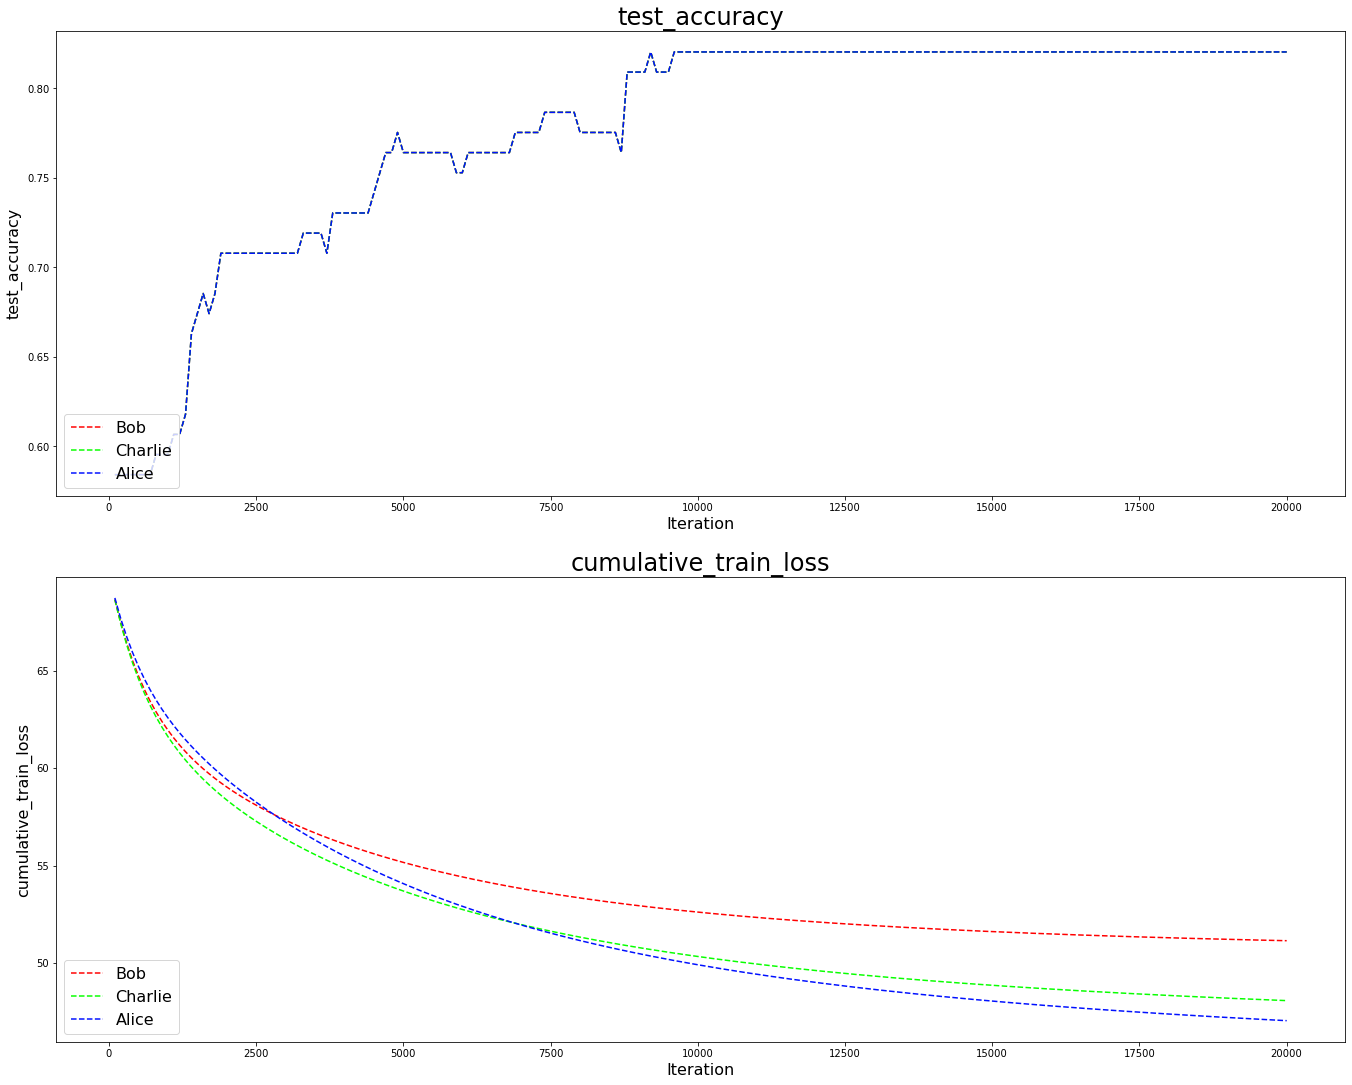

In [20]:
def get_cmap(n, name='hsv'):
    '''
    Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.
    '''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(n_agents + 1)

fig, axs = plt.subplots(len(statistics), 1, figsize=(20, 16))
fig.tight_layout(pad=6.0)

for i, (func_name, node_stat) in enumerate(statistics.items()):
    axs[i].set_title(func_name, fontsize=24)
    axs[i].set_xlabel('Iteration', fontsize=18)
    axs[i].set_ylabel(func_name, fontsize=18)
    for j, (node_name, stat) in enumerate(node_stat.items()):
        axs[i].plot(stat['iters'], stat['values'], label=node_name, linestyle='--', color=cmap(j))
    axs[i].legend(loc=3, fontsize=16)
plt.show()